# Notebook: main.ipynb
## Proyecto: Pipeline NLP para Análisis de Twitter

**Fecha:** Octubre 2025  
**Dataset:** preprocessed_data.csv
 
---

## 📋 Objetivos del Main
 
1. Carga de datos preprocesados
2. Representaciones de texto (BoW, TF-IDF, Co-ocurrencia, PPMI, Embeddings)
3. Modelos probabilísticos (N-gramas, entropía, perplejidad)
4. Clasificación supervisada (Naive Bayes, SVM, CNN)
5. Evaluación y comparación

# -----
# Descarga y verificacion de Recursos
# -----

In [2]:
import nltk

# Descargar recursos necesarios
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

print("✅ Recursos de NLTK descargados")

✅ Recursos de NLTK descargados


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
import sys

def check_package(package_name):
    try:
        __import__(package_name)
        print(f"✅ {package_name}")
        return True
    except ImportError:
        print(f"❌ {package_name} - NO INSTALADO")
        return False

print("\n📦 VERIFICACIÓN DE PAQUETES:")
print("─" * 60)

# Básicos
check_package('numpy')
check_package('pandas')
check_package('matplotlib')
check_package('seaborn')

# NLP
check_package('spacy')
check_package('nltk')
check_package('Levenshtein')
check_package('rapidfuzz')
check_package('wordcloud')
check_package('gensim')

# ML
check_package('sklearn')

# Deep Learning
check_package('torch')
check_package('transformers')

# Visualización
check_package('plotly')
check_package('yellowbrick')

# Utilidades
check_package('tqdm')


📦 VERIFICACIÓN DE PAQUETES:
────────────────────────────────────────────────────────────
✅ numpy
✅ pandas
✅ matplotlib
✅ seaborn
✅ spacy
✅ nltk
✅ Levenshtein
✅ rapidfuzz
✅ wordcloud
✅ gensim
✅ sklearn
✅ torch


Disabling PyTorch because PyTorch >= 2.1 is required but found 1.7.1+cu110
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


✅ transformers
✅ plotly
✅ yellowbrick
✅ tqdm


True

# -----
# SECCIÓN 1: IMPORTACIONES Y CONFIGURACIÓN
# -----

In [4]:
print("="*80)
print("PIPELINE COMPLETO DE NLP - INICIANDO")
print("="*80)

# Básicos
import pandas as pd
import numpy as np
import pickle
import json
import warnings
from collections import Counter, defaultdict
from itertools import combinations
import time
warnings.filterwarnings('ignore')

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# NLP y procesamiento
import spacy
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                            accuracy_score, f1_score, precision_score, 
                            recall_score, roc_auc_score, roc_curve)

# Modelos de clasificación
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Embeddings y modelos de lenguaje
from gensim.models import Word2Vec, FastText
from gensim.models.phrases import Phrases, Phraser
import gensim.downloader as api

# Deep Learning (opcional)
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    PYTORCH_AVAILABLE = True
except ImportError:
    PYTORCH_AVAILABLE = False
    print("⚠️  PyTorch no disponible, se omitirán modelos CNN")


# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Configuración de semilla para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("\n✅ Librerías importadas correctamente")
print(f"✅ PyTorch disponible: {PYTORCH_AVAILABLE}")

PIPELINE COMPLETO DE NLP - INICIANDO

✅ Librerías importadas correctamente
✅ PyTorch disponible: True


# -----
# SECCIÓN 2: CARGA DE DATOS PREPROCESADOS
# -----

In [5]:
print("\n" + "="*80)
print("SECCIÓN 2: CARGA DE DATOS PREPROCESADOS")
print("="*80)

# Cargar datos preprocesados
print("\n📂 Cargando datos preprocesados...")
df = pd.read_pickle('../data/processed/preprocessed_data.pkl')
print(f"✅ Datos cargados: {len(df):,} documentos")

# Cargar estadísticas
with open('../data/processed/preprocessing_stats.json', 'r') as f:
    preprocessing_stats = json.load(f)

print("\n📊 Estadísticas del corpus:")
print(f"   ├─ Total de documentos: {preprocessing_stats['total_documents']:,}")
print(f"   ├─ Total de tokens: {preprocessing_stats['total_tokens']:,}")
print(f"   ├─ Vocabulario: {preprocessing_stats['vocabulary_size']:,}")
print(f"   ├─ Diversidad léxica: {preprocessing_stats['lexical_diversity']:.4f}")
print(f"   └─ Promedio tokens/doc: {preprocessing_stats['avg_tokens_per_doc']:.2f}")

# Mostrar distribución de clases
print("\n📊 Distribución de clases:")
class_dist = df['category'].value_counts().sort_index()
for cat, count in class_dist.items():
    print(f"   Clase {int(cat)}: {count:,} documentos ({count/len(df)*100:.2f}%)")

# Preparar datos
print("\n🔧 Preparando datos para el pipeline...")
X_text = df['lemmatized_text'].values  # Texto lematizado
X_tokens = df['tokens'].values  # Tokens como lista
y = df['category'].values  # Etiquetas

print(f"✅ Datos preparados:")
print(f"   ├─ X_text shape: {X_text.shape}")
print(f"   ├─ X_tokens: {len(X_tokens)} documentos")
print(f"   └─ y shape: {y.shape}")


SECCIÓN 2: CARGA DE DATOS PREPROCESADOS

📂 Cargando datos preprocesados...
✅ Datos cargados: 162,586 documentos

📊 Estadísticas del corpus:
   ├─ Total de documentos: 162,586
   ├─ Total de tokens: 3,053,743
   ├─ Vocabulario: 104,330
   ├─ Diversidad léxica: 0.0342
   └─ Promedio tokens/doc: 18.78

📊 Distribución de clases:
   Clase -1: 35,498 documentos (21.83%)
   Clase 0: 54,910 documentos (33.77%)
   Clase 1: 72,178 documentos (44.39%)

🔧 Preparando datos para el pipeline...
✅ Datos preparados:
   ├─ X_text shape: (162586,)
   ├─ X_tokens: 162586 documentos
   └─ y shape: (162586,)


# -----
# SECCIÓN 3: REPRESENTACIONES DE TEXTO
# -----

In [6]:
print("\n" + "="*80)
print("SECCIÓN 3: REPRESENTACIONES DE TEXTO")
print("="*80)

# ---------------------------------------------------------------------------
# 3.1 BAG OF WORDS (BoW)
# ---------------------------------------------------------------------------

print("\n" + "-"*80)
print("3.1 BAG OF WORDS (BoW)")
print("-"*80)

print("\n🔄 Construyendo representación BoW...")
bow_vectorizer = CountVectorizer(
    max_features=5000,  # Top 5000 palabras más frecuentes
    min_df=5,           # Palabra debe aparecer en al menos 5 documentos
    max_df=0.8          # Palabra no debe aparecer en más del 80% de documentos
)

X_bow = bow_vectorizer.fit_transform(X_text)
bow_feature_names = bow_vectorizer.get_feature_names_out()

print(f"✅ Matriz BoW creada:")
print(f"   ├─ Shape: {X_bow.shape}")
print(f"   ├─ Vocabulario: {len(bow_feature_names)} palabras")
print(f"   ├─ Sparsity: {(1 - X_bow.nnz / (X_bow.shape[0] * X_bow.shape[1]))*100:.2f}%")
print(f"   └─ Memoria: {X_bow.data.nbytes / 1024**2:.2f} MB")

# Top palabras más frecuentes en BoW
bow_word_counts = np.asarray(X_bow.sum(axis=0)).flatten()
top_bow_indices = bow_word_counts.argsort()[-20:][::-1]
print("\n🔝 Top 20 palabras más frecuentes (BoW):")
for i, idx in enumerate(top_bow_indices, 1):
    print(f"   {i:2d}. {bow_feature_names[idx]:20s} | {bow_word_counts[idx]:,} ocurrencias")


SECCIÓN 3: REPRESENTACIONES DE TEXTO

--------------------------------------------------------------------------------
3.1 BAG OF WORDS (BoW)
--------------------------------------------------------------------------------

🔄 Construyendo representación BoW...
✅ Matriz BoW creada:
   ├─ Shape: (162586, 5000)
   ├─ Vocabulario: 5000 palabras
   ├─ Sparsity: 99.70%
   └─ Memoria: 18.73 MB

🔝 Top 20 palabras más frecuentes (BoW):
    1. the                  | 104,521 ocurrencias
    2. and                  | 67,365 ocurrencias
    3. for                  | 52,445 ocurrencias
    4. you                  | 38,980 ocurrencias
    5. not                  | 29,436 ocurrencias
    6. will                 | 28,946 ocurrencias
    7. this                 | 28,609 ocurrencias
    8. that                 | 28,263 ocurrencias
    9. are                  | 27,848 ocurrencias
   10. with                 | 21,020 ocurrencias
   11. have                 | 19,808 ocurrencias
   12. but                  

In [7]:
# ---------------------------------------------------------------------------
# 3.2 TF-IDF
# ---------------------------------------------------------------------------

print("\n" + "-"*80)
print("3.2 TF-IDF (Term Frequency - Inverse Document Frequency)")
print("-"*80)

print("\n🔄 Construyendo representación TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.8,
    sublinear_tf=True,  # Usa escala logarítmica para TF
    use_idf=True
)

X_tfidf = tfidf_vectorizer.fit_transform(X_text)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"✅ Matriz TF-IDF creada:")
print(f"   ├─ Shape: {X_tfidf.shape}")
print(f"   ├─ Vocabulario: {len(tfidf_feature_names)} palabras")
print(f"   ├─ Sparsity: {(1 - X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1]))*100:.2f}%")
print(f"   └─ Memoria: {X_tfidf.data.nbytes / 1024**2:.2f} MB")

# Palabras con mayor TF-IDF promedio
tfidf_means = np.asarray(X_tfidf.mean(axis=0)).flatten()
top_tfidf_indices = tfidf_means.argsort()[-20:][::-1]
print("\n🔝 Top 20 palabras con mayor TF-IDF promedio:")
for i, idx in enumerate(top_tfidf_indices, 1):
    print(f"   {i:2d}. {tfidf_feature_names[idx]:20s} | TF-IDF: {tfidf_means[idx]:.6f}")


--------------------------------------------------------------------------------
3.2 TF-IDF (Term Frequency - Inverse Document Frequency)
--------------------------------------------------------------------------------

🔄 Construyendo representación TF-IDF...
✅ Matriz TF-IDF creada:
   ├─ Shape: (162586, 5000)
   ├─ Vocabulario: 5000 palabras
   ├─ Sparsity: 99.70%
   └─ Memoria: 18.73 MB

🔝 Top 20 palabras con mayor TF-IDF promedio:
    1. the                  | TF-IDF: 0.043945
    2. and                  | TF-IDF: 0.034242
    3. for                  | TF-IDF: 0.031580
    4. you                  | TF-IDF: 0.025859
    5. will                 | TF-IDF: 0.021694
    6. this                 | TF-IDF: 0.021355
    7. not                  | TF-IDF: 0.021047
    8. are                  | TF-IDF: 0.020120
    9. that                 | TF-IDF: 0.019558
   10. with                 | TF-IDF: 0.017151
   11. india                | TF-IDF: 0.015509
   12. have                 | TF-IDF: 0.0153

In [8]:
# ---------------------------------------------------------------------------
# 3.3 MATRIZ DE CO-OCURRENCIA Y PPMI
# ---------------------------------------------------------------------------

print("\n" + "-"*80)
print("3.3 MATRIZ DE CO-OCURRENCIA Y PPMI")
print("-"*80)

def build_cooccurrence_matrix(tokens_list, window_size=5, vocab_size=1000):
    """
    Construye matriz de co-ocurrencia con ventana deslizante
    """
    print(f"\n🔄 Construyendo matriz de co-ocurrencia (ventana={window_size})...")
    
    # Construir vocabulario limitado (palabras más frecuentes)
    all_words = [word for tokens in tokens_list for word in tokens]
    word_counts = Counter(all_words)
    vocab = [word for word, _ in word_counts.most_common(vocab_size)]
    word_to_idx = {word: i for i, word in enumerate(vocab)}
    
    # Inicializar matriz
    cooc_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    # Contar co-ocurrencias
    for tokens in tokens_list:
        for i, word in enumerate(tokens):
            if word not in word_to_idx:
                continue
            
            word_idx = word_to_idx[word]
            
            # Ventana de contexto
            start = max(0, i - window_size)
            end = min(len(tokens), i + window_size + 1)
            
            for j in range(start, end):
                if i != j and tokens[j] in word_to_idx:
                    context_idx = word_to_idx[tokens[j]]
                    cooc_matrix[word_idx, context_idx] += 1
    
    return cooc_matrix, vocab, word_to_idx

# Construir matriz de co-ocurrencia
cooc_matrix, cooc_vocab, word_to_idx = build_cooccurrence_matrix(
    X_tokens, 
    window_size=5, 
    vocab_size=1000
)

print(f"✅ Matriz de co-ocurrencia creada:")
print(f"   ├─ Shape: {cooc_matrix.shape}")
print(f"   ├─ Total co-ocurrencias: {cooc_matrix.sum():,}")
print(f"   └─ Densidad: {(cooc_matrix > 0).sum() / cooc_matrix.size * 100:.2f}%")

# Calcular PPMI (Positive Pointwise Mutual Information)
def calculate_ppmi(cooc_matrix, k=1):
    """
    Calcula PPMI a partir de matriz de co-ocurrencia
    PMI(w,c) = log( P(w,c) / (P(w) * P(c)) )
    PPMI(w,c) = max(0, PMI(w,c))
    """
    print("\n🔄 Calculando PPMI...")
    
    # Probabilidades
    word_counts = cooc_matrix.sum(axis=1)
    context_counts = cooc_matrix.sum(axis=0)
    total = cooc_matrix.sum()
    
    # Evitar división por cero
    word_counts = np.maximum(word_counts, 1)
    context_counts = np.maximum(context_counts, 1)
    
    # PMI
    ppmi_matrix = np.zeros_like(cooc_matrix, dtype=np.float32)
    
    for i in range(cooc_matrix.shape[0]):
        for j in range(cooc_matrix.shape[1]):
            if cooc_matrix[i, j] > 0:
                p_wc = cooc_matrix[i, j] / total
                p_w = word_counts[i] / total
                p_c = context_counts[j] / total
                
                pmi = np.log2((p_wc + k) / (p_w * p_c))
                ppmi_matrix[i, j] = max(0, pmi)
    
    return ppmi_matrix

ppmi_matrix = calculate_ppmi(cooc_matrix)

print(f"✅ Matriz PPMI calculada:")
print(f"   ├─ Shape: {ppmi_matrix.shape}")
print(f"   ├─ Valores no-cero: {(ppmi_matrix > 0).sum():,}")
print(f"   └─ PPMI promedio: {ppmi_matrix[ppmi_matrix > 0].mean():.4f}")

# Ejemplo de palabras más asociadas
example_word = cooc_vocab[0]  # Primera palabra del vocabulario
if example_word in word_to_idx:
    word_idx = word_to_idx[example_word]
    top_contexts = ppmi_matrix[word_idx].argsort()[-10:][::-1]
    print(f"\n📝 Palabras más asociadas con '{example_word}' (según PPMI):")
    for i, ctx_idx in enumerate(top_contexts, 1):
        print(f"   {i:2d}. {cooc_vocab[ctx_idx]:20s} | PPMI: {ppmi_matrix[word_idx, ctx_idx]:.4f}")



--------------------------------------------------------------------------------
3.3 MATRIZ DE CO-OCURRENCIA Y PPMI
--------------------------------------------------------------------------------

🔄 Construyendo matriz de co-ocurrencia (ventana=5)...
✅ Matriz de co-ocurrencia creada:
   ├─ Shape: (1000, 1000)
   ├─ Total co-ocurrencias: 12,908,400
   └─ Densidad: 74.43%

🔄 Calculando PPMI...
✅ Matriz PPMI calculada:
   ├─ Shape: (1000, 1000)
   ├─ Valores no-cero: 744,316
   └─ PPMI promedio: 21.3387

📝 Palabras más asociadas con 'the' (según PPMI):
    1. hey                  | PPMI: 17.1414
    2. wow                  | PPMI: 17.0928
    3. sab                  | PPMI: 17.0798
    4. yeah                 | PPMI: 17.0473
    5. din                  | PPMI: 17.0133
    6. madam                | PPMI: 16.9408
    7. ghar                 | PPMI: 16.9243
    8. gas                  | PPMI: 16.8957
    9. mein                 | PPMI: 16.8777
   10. absolutely           | PPMI: 16.8717


In [9]:
# ---------------------------------------------------------------------------
# 3.4 EMBEDDINGS - WORD2VEC
# ---------------------------------------------------------------------------

print("\n" + "-"*80)
print("3.4 EMBEDDINGS - WORD2VEC")
print("-"*80)

print("\n🔄 Entrenando modelo Word2Vec...")
# Preparar datos para Word2Vec (lista de listas de tokens)
sentences_for_w2v = list(X_tokens)

# Entrenar Word2Vec
w2v_model = Word2Vec(
    sentences=sentences_for_w2v,
    vector_size=100,        # Dimensión de los embeddings
    window=5,               # Ventana de contexto
    min_count=5,            # Frecuencia mínima
    workers=4,              # Paralelización
    sg=0,                   # 0=CBOW, 1=Skip-gram
    epochs=10,
    seed=RANDOM_SEED
)

print(f"✅ Word2Vec entrenado:")
print(f"   ├─ Vocabulario: {len(w2v_model.wv)} palabras")
print(f"   ├─ Dimensión: {w2v_model.wv.vector_size}")
print(f"   └─ Algoritmo: {'Skip-gram' if w2v_model.sg else 'CBOW'}")

# Guardar modelo
w2v_model.save('../data/embeddings/word2vec.model')
print("💾 Modelo guardado: word2vec.model")

# Ejemplos de similitud
print("\n📝 Ejemplos de similitud semántica (Word2Vec):")
test_words = [word for word in ['gobierno', 'política', 'gente', 'país'] 
              if word in w2v_model.wv]

for word in test_words[:3]:
    similar = w2v_model.wv.most_similar(word, topn=5)
    print(f"\n   Similares a '{word}':")
    for sim_word, score in similar:
        print(f"      - {sim_word:15s} (similaridad: {score:.4f})")

# Crear embeddings de documentos (promedio de palabras)
def document_vector(tokens, model):
    """Calcula vector de documento como promedio de word embeddings"""
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.wv.vector_size)

print("\n🔄 Creando embeddings de documentos...")
X_w2v = np.array([document_vector(tokens, w2v_model) for tokens in X_tokens])
print(f"✅ Embeddings de documentos creados: {X_w2v.shape}")



--------------------------------------------------------------------------------
3.4 EMBEDDINGS - WORD2VEC
--------------------------------------------------------------------------------

🔄 Entrenando modelo Word2Vec...
✅ Word2Vec entrenado:
   ├─ Vocabulario: 21127 palabras
   ├─ Dimensión: 100
   └─ Algoritmo: CBOW
💾 Modelo guardado: word2vec.model

📝 Ejemplos de similitud semántica (Word2Vec):

🔄 Creando embeddings de documentos...
✅ Embeddings de documentos creados: (162586, 100)


In [10]:
# ---------------------------------------------------------------------------
# 3.5 EMBEDDINGS - FASTTEXT
# ---------------------------------------------------------------------------

print("\n" + "-"*80)
print("3.5 EMBEDDINGS - FASTTEXT")
print("-"*80)

print("\n🔄 Entrenando modelo FastText...")
fasttext_model = FastText(
    sentences=sentences_for_w2v,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=0,
    epochs=10,
    seed=RANDOM_SEED
)

print(f"✅ FastText entrenado:")
print(f"   ├─ Vocabulario: {len(fasttext_model.wv)} palabras")
print(f"   ├─ Dimensión: {fasttext_model.wv.vector_size}")
print(f"   └─ Ventaja: Maneja palabras fuera de vocabulario (OOV)")

# Guardar modelo
fasttext_model.save('../data/embeddings/fasttext.model')
print("💾 Modelo guardado: fasttext.model")

# Crear embeddings de documentos con FastText
print("\n🔄 Creando embeddings de documentos (FastText)...")
X_fasttext = np.array([document_vector(tokens, fasttext_model) for tokens in X_tokens])
print(f"✅ Embeddings de documentos creados: {X_fasttext.shape}")


--------------------------------------------------------------------------------
3.5 EMBEDDINGS - FASTTEXT
--------------------------------------------------------------------------------

🔄 Entrenando modelo FastText...
✅ FastText entrenado:
   ├─ Vocabulario: 21127 palabras
   ├─ Dimensión: 100
   └─ Ventaja: Maneja palabras fuera de vocabulario (OOV)
💾 Modelo guardado: fasttext.model

🔄 Creando embeddings de documentos (FastText)...
✅ Embeddings de documentos creados: (162586, 100)



--------------------------------------------------------------------------------
3.6 COMPARACIÓN VISUAL DE REPRESENTACIONES
--------------------------------------------------------------------------------

🔄 Aplicando PCA para visualización (muestra de 3000 docs)...
✅ Visualización PCA guardada: representations_pca.png


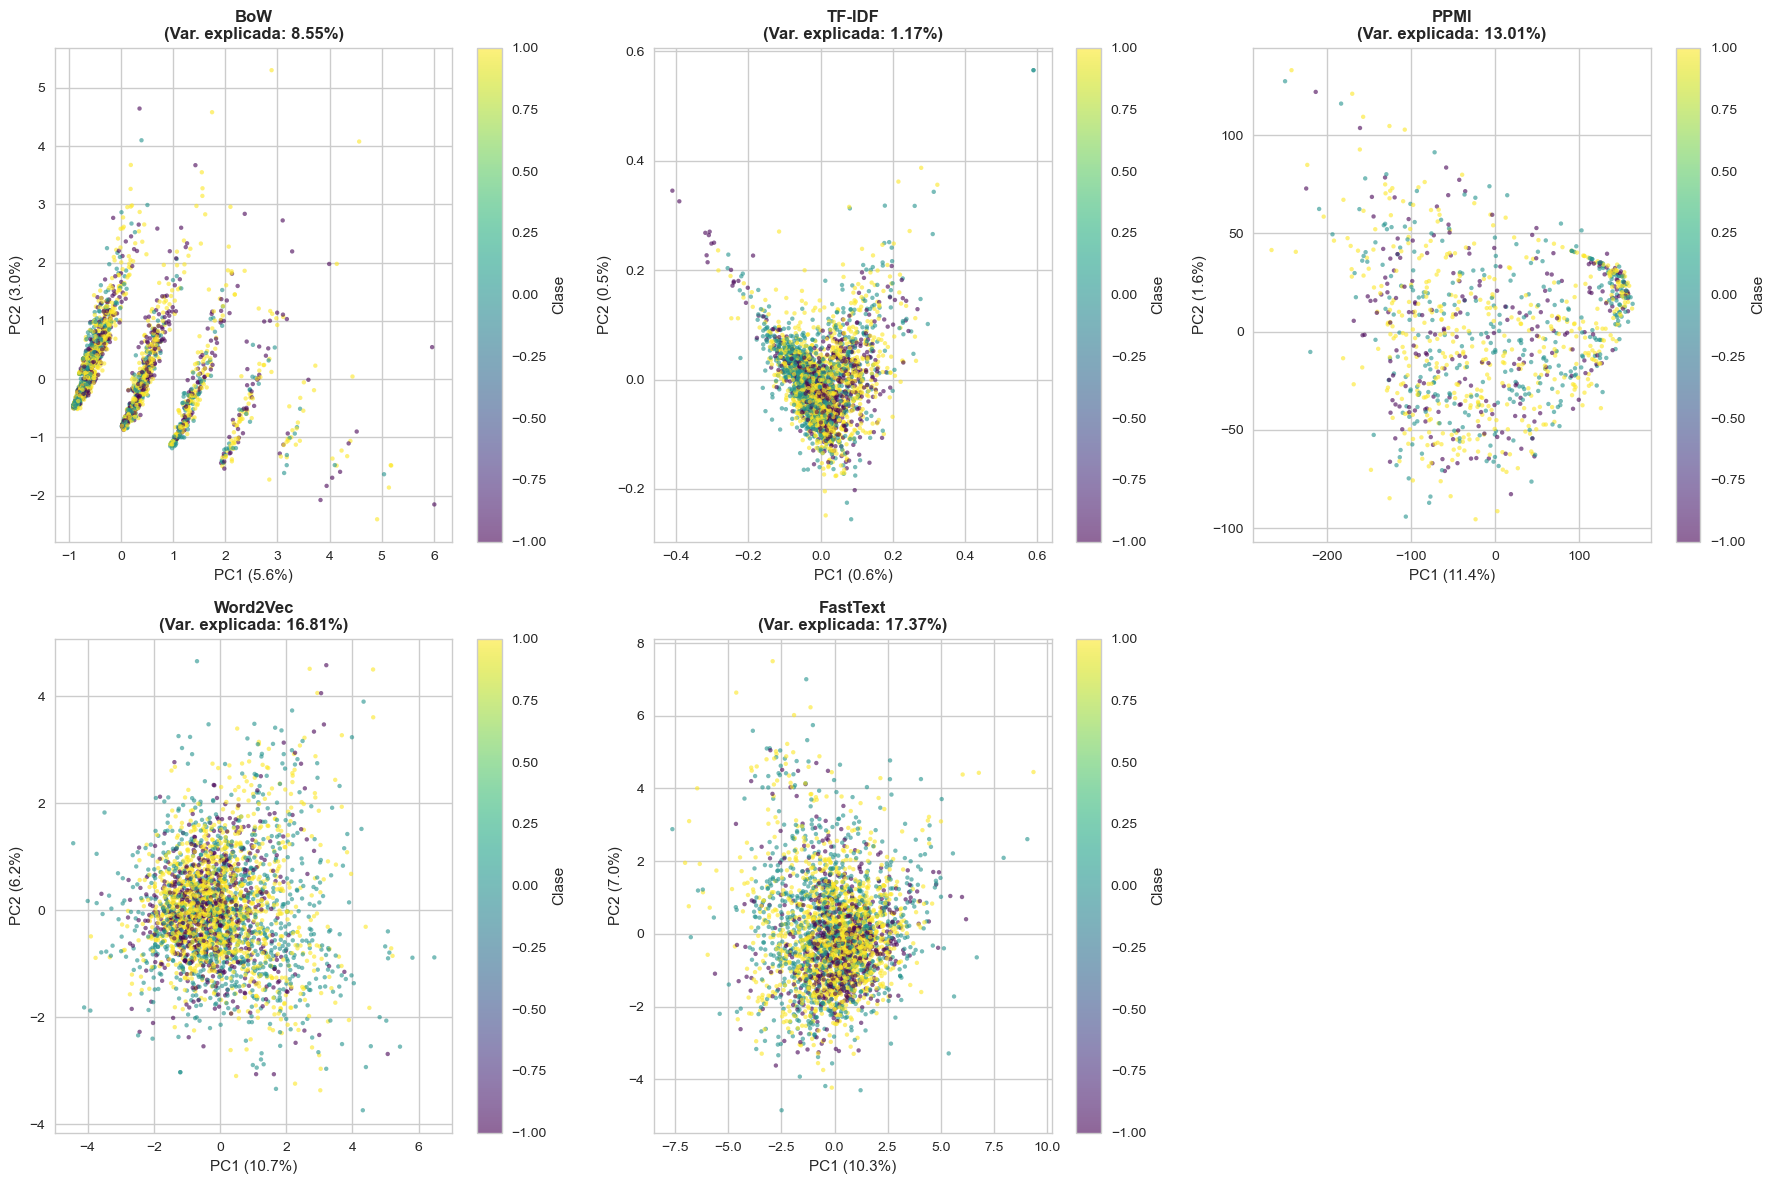


🔄 Aplicando t-SNE a Word2Vec (esto puede tardar)...
✅ Visualización t-SNE guardada: tsne_word2vec.png


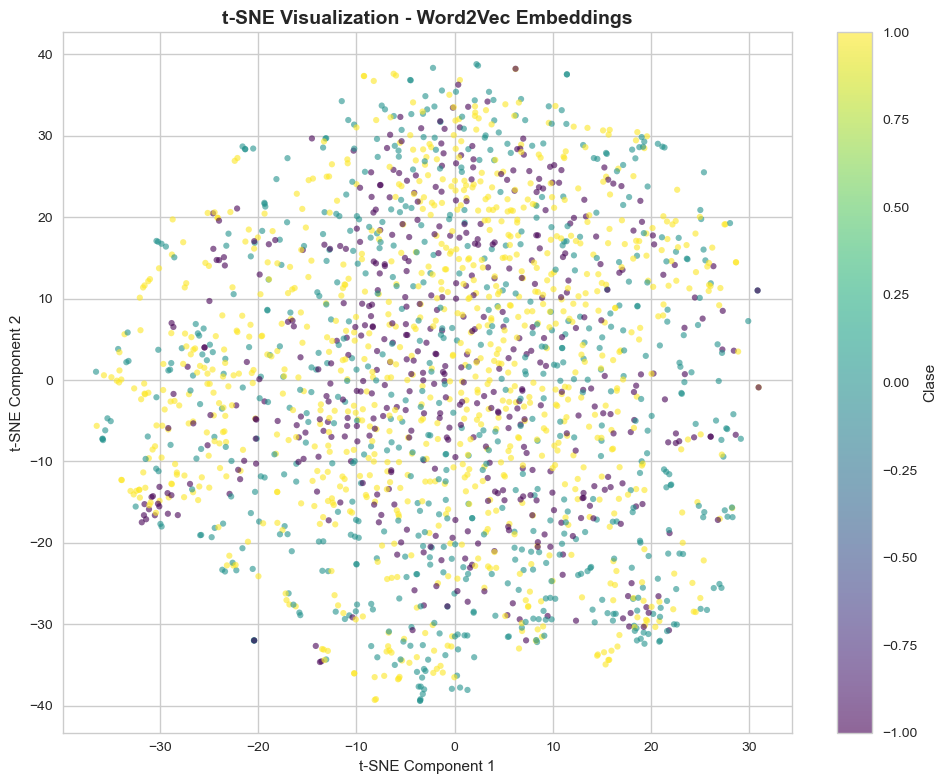


✅ SECCIÓN 3 COMPLETADA: REPRESENTACIONES DE TEXTO

Representaciones creadas:
   ✅ Bag of Words (BoW)
   ✅ TF-IDF
   ✅ Co-ocurrencia + PPMI
   ✅ Word2Vec embeddings
   ✅ FastText embeddings
   ✅ Visualizaciones PCA y t-SNE

💾 Guardando representaciones...
✅ Representaciones guardadas: representations.pkl


In [11]:
# ---------------------------------------------------------------------------
# 3.6 COMPARACIÓN VISUAL DE REPRESENTACIONES (PCA y t-SNE)
# ---------------------------------------------------------------------------

print("\n" + "-"*80)
print("3.6 COMPARACIÓN VISUAL DE REPRESENTACIONES")
print("-"*80)

def visualize_representations_pca(representations_dict, y_labels, n_components=2, sample_size=5000):
    """
    Visualiza múltiples representaciones usando PCA
    """
    print(f"\n🔄 Aplicando PCA para visualización (muestra de {sample_size} docs)...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Muestrear datos
    if len(y_labels) > sample_size:
        indices = np.random.choice(len(y_labels), sample_size, replace=False)
    else:
        indices = np.arange(len(y_labels))
    
    for idx, (name, X) in enumerate(representations_dict.items()):
        if idx >= len(axes):
            break
        
        # --- 🔧 Ajuste de índices según el tamaño real de X ---
        n_samples = X.shape[0]
        max_sample = min(sample_size, n_samples)
        indices = np.random.choice(n_samples, max_sample, replace=False)
        
        X_sample = X[indices]
        y_sample = y_labels[indices]
        
        # PCA
        pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
        X_pca = pca.fit_transform(X_sample.toarray() if hasattr(X_sample, 'toarray') else X_sample)
        
        # Plot
        scatter = axes[idx].scatter(
            X_pca[:, 0], X_pca[:, 1],
            c=y_sample, cmap='viridis',
            alpha=0.6, s=10, edgecolors='none'
        )
        axes[idx].set_title(f'{name}\n(Var. explicada: {pca.explained_variance_ratio_.sum():.2%})',
                        fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        axes[idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        plt.colorbar(scatter, ax=axes[idx], label='Clase')
    
    # Eliminar ejes vacíos
    for idx in range(len(representations_dict), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.savefig('../results/representations_pca.png', dpi=300, bbox_inches='tight')
    print("✅ Visualización PCA guardada: representations_pca.png")
    plt.show()

# Preparar representaciones para visualización
representations = {
    'BoW': X_bow,
    'TF-IDF': X_tfidf,
    'PPMI': ppmi_matrix[:len(df)],  # Ajustar dimensión
    'Word2Vec': X_w2v,
    'FastText': X_fasttext
}

# Crear visualización PCA
visualize_representations_pca(representations, y, sample_size=3000)

# t-SNE para Word2Vec (más lento)
print("\n🔄 Aplicando t-SNE a Word2Vec (esto puede tardar)...")
sample_size = 2000
indices = np.random.choice(len(y), min(sample_size, len(y)), replace=False)
X_tsne_sample = X_w2v[indices]
y_tsne_sample = y[indices]

tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_tsne_sample)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                     c=y_tsne_sample, cmap='viridis', 
                     alpha=0.6, s=20, edgecolors='none')
plt.colorbar(scatter, label='Clase')
plt.title('t-SNE Visualization - Word2Vec Embeddings', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.savefig('../results/tsne_word2vec.png', dpi=300, bbox_inches='tight')
print("✅ Visualización t-SNE guardada: tsne_word2vec.png")
plt.show()

print("\n" + "="*80)
print("✅ SECCIÓN 3 COMPLETADA: REPRESENTACIONES DE TEXTO")
print("="*80)
print("\nRepresentaciones creadas:")
print("   ✅ Bag of Words (BoW)")
print("   ✅ TF-IDF")
print("   ✅ Co-ocurrencia + PPMI")
print("   ✅ Word2Vec embeddings")
print("   ✅ FastText embeddings")
print("   ✅ Visualizaciones PCA y t-SNE")

# Guardar representaciones
print("\n💾 Guardando representaciones...")
with open('../data/processed/representations.pkl', 'wb') as f:
    pickle.dump({
        'X_bow': X_bow,
        'X_tfidf': X_tfidf,
        'X_w2v': X_w2v,
        'X_fasttext': X_fasttext,
        'bow_vectorizer': bow_vectorizer,
        'tfidf_vectorizer': tfidf_vectorizer,
        'ppmi_matrix': ppmi_matrix,
        'cooc_vocab': cooc_vocab,
        'word_to_idx': word_to_idx
    }, f)
print("✅ Representaciones guardadas: representations.pkl")

# -----
# SECCIÓN 4: MODELOS PROBABILÍSTICOS - N-GRAMAS
# -----

In [12]:
print("\n" + "="*80)
print("SECCIÓN 4: MODELOS PROBABILÍSTICOS - N-GRAMAS")
print("="*80)

# ---------------------------------------------------------------------------
# 4.1 CONSTRUCCIÓN DE MODELOS N-GRAMAS
# ---------------------------------------------------------------------------

print("\n" + "-"*80)
print("4.1 CONSTRUCCIÓN DE MODELOS N-GRAMAS")
print("-"*80)

class NgramLanguageModel:
    """Modelo de lenguaje basado en N-gramas con smoothing"""
    
    def __init__(self, n=2, smoothing='laplace', alpha=1.0):
        """
        n: orden del modelo (2=bigrama, 3=trigrama)
        smoothing: 'laplace', 'add-k', o 'none'
        alpha: parámetro de smoothing
        """
        self.n = n
        self.smoothing = smoothing
        self.alpha = alpha
        self.ngram_counts = Counter()
        self.context_counts = Counter()
        self.vocabulary = set()
        self.vocab_size = 0
        
    def train(self, tokens_list):
        """Entrena el modelo con lista de documentos tokenizados"""
        print(f"\n🔄 Entrenando modelo {self.n}-grama...")
        
        for tokens in tokens_list:
            # Añadir tokens especiales
            padded = ['<START>'] * (self.n - 1) + tokens + ['<END>']
            
            # Actualizar vocabulario
            self.vocabulary.update(tokens)
            
            # Contar n-gramas
            for i in range(len(padded) - self.n + 1):
                ngram = tuple(padded[i:i + self.n])
                context = ngram[:-1]
                
                self.ngram_counts[ngram] += 1
                self.context_counts[context] += 1
        
        self.vocab_size = len(self.vocabulary)
        print(f"✅ Modelo entrenado:")
        print(f"   ├─ N-gramas únicos: {len(self.ngram_counts):,}")
        print(f"   ├─ Contextos únicos: {len(self.context_counts):,}")
        print(f"   └─ Vocabulario: {self.vocab_size:,} palabras")
    
    def get_probability(self, ngram):
        """Calcula probabilidad de un n-grama con smoothing"""
        context = ngram[:-1]
        
        if self.smoothing == 'laplace' or self.smoothing == 'add-k':
            numerator = self.ngram_counts[ngram] + self.alpha
            denominator = self.context_counts[context] + (self.alpha * self.vocab_size)
        else:  # no smoothing
            numerator = self.ngram_counts[ngram]
            denominator = self.context_counts[context]
        
        if denominator == 0:
            return 0.0
        
        return numerator / denominator
    
    def entropy(self, tokens_list):
        """Calcula la entropía promedio (bits por token)"""
        log_prob_sum = 0
        N = 0
        
        for tokens in tokens_list:
            padded = ['<START>'] * (self.n - 1) + tokens + ['<END>']
            
            for i in range(len(padded) - self.n + 1):
                ngram = tuple(padded[i:i + self.n])
                prob = self.get_probability(ngram)
                
                if prob > 0:
                    log_prob_sum += np.log2(prob)
                    N += 1
        
        if N == 0:
            return float('inf')
        
        return -log_prob_sum / N

    def perplexity(self, tokens_list):
        """Calcula la perplejidad a partir de la entropía"""
        H = self.entropy(tokens_list)
        return 2 ** H
    
    def generate_text(self, seed_words=None, max_length=20):
        """Genera texto usando el modelo de lenguaje"""
        if seed_words is None:
            current = ['<START>'] * (self.n - 1)
        else:
            current = ['<START>'] * (self.n - 1) + seed_words
        
        generated = []
        
        for _ in range(max_length):
            context = tuple(current[-(self.n-1):])
            
            # Obtener posibles continuaciones
            candidates = [(ngram, count) for ngram, count in self.ngram_counts.items()
                         if ngram[:-1] == context]
            
            if not candidates:
                break
            
            # Seleccionar siguiente palabra basado en probabilidades
            total = sum(count for _, count in candidates)
            probs = [count / total for _, count in candidates]
            next_word = np.random.choice([ngram[-1] for ngram, _ in candidates], p=probs)
            
            if next_word == '<END>':
                break
            
            generated.append(next_word)
            current.append(next_word)
        
        return ' '.join(generated)

# Dividir datos en train/test
print("\n🔄 Dividiendo datos en train/test...")
train_tokens, test_tokens, y_train_ngram, y_test_ngram = train_test_split(
    X_tokens, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
print(f"✅ Train: {len(train_tokens):,} docs | Test: {len(test_tokens):,} docs")


SECCIÓN 4: MODELOS PROBABILÍSTICOS - N-GRAMAS

--------------------------------------------------------------------------------
4.1 CONSTRUCCIÓN DE MODELOS N-GRAMAS
--------------------------------------------------------------------------------

🔄 Dividiendo datos en train/test...
✅ Train: 130,068 docs | Test: 32,518 docs


In [13]:
# ---------------------------------------------------------------------------
# 4.2 ENTRENAR MODELOS N-GRAMAS
# ---------------------------------------------------------------------------

print("\n" + "-"*80)
print("4.2 ENTRENAR MODELOS N-GRAMAS")
print("-"*80)

# Entrenar diferentes modelos
models = {}

# Bigrama sin smoothing
print("\n📊 Modelo 1: Bigrama sin smoothing")
bigram_no_smooth = NgramLanguageModel(n=2, smoothing='none')
bigram_no_smooth.train(train_tokens)
models['Bigram (no smoothing)'] = bigram_no_smooth

# Bigrama con Laplace
print("\n📊 Modelo 2: Bigrama con Laplace smoothing")
bigram_laplace = NgramLanguageModel(n=2, smoothing='laplace', alpha=1.0)
bigram_laplace.train(train_tokens)
models['Bigram (Laplace)'] = bigram_laplace

# Bigrama con Add-k (k=0.1)
print("\n📊 Modelo 3: Bigrama con Add-k smoothing")
bigram_addk = NgramLanguageModel(n=2, smoothing='add-k', alpha=0.1)
bigram_addk.train(train_tokens)
models['Bigram (Add-k, α=0.1)'] = bigram_addk

# Trigrama con Laplace
print("\n📊 Modelo 4: Trigrama con Laplace smoothing")
trigram_laplace = NgramLanguageModel(n=3, smoothing='laplace', alpha=1.0)
trigram_laplace.train(train_tokens)
models['Trigram (Laplace)'] = trigram_laplace


--------------------------------------------------------------------------------
4.2 ENTRENAR MODELOS N-GRAMAS
--------------------------------------------------------------------------------

📊 Modelo 1: Bigrama sin smoothing

🔄 Entrenando modelo 2-grama...
✅ Modelo entrenado:
   ├─ N-gramas únicos: 974,291
   ├─ Contextos únicos: 91,222
   └─ Vocabulario: 91,221 palabras

📊 Modelo 2: Bigrama con Laplace smoothing

🔄 Entrenando modelo 2-grama...
✅ Modelo entrenado:
   ├─ N-gramas únicos: 974,291
   ├─ Contextos únicos: 91,222
   └─ Vocabulario: 91,221 palabras

📊 Modelo 3: Bigrama con Add-k smoothing

🔄 Entrenando modelo 2-grama...
✅ Modelo entrenado:
   ├─ N-gramas únicos: 974,291
   ├─ Contextos únicos: 91,222
   └─ Vocabulario: 91,221 palabras

📊 Modelo 4: Trigrama con Laplace smoothing

🔄 Entrenando modelo 3-grama...
✅ Modelo entrenado:
   ├─ N-gramas únicos: 1,891,946
   ├─ Contextos únicos: 956,841
   └─ Vocabulario: 91,221 palabras



--------------------------------------------------------------------------------
4.3 EVALUACIÓN: ENTROPÍA Y PERPLEJIDAD
--------------------------------------------------------------------------------

📊 Evaluando modelos en conjunto de test...
────────────────────────────────────────────────────────────────────────────────

🔄 Evaluando: Bigram (no smoothing)
   ├─ Entropía: 6.9600 bits
   ├─ Perplejidad: 124.50
   └─ Tiempo: 0.09s

🔄 Evaluando: Bigram (Laplace)
   ├─ Entropía: 13.2283 bits
   ├─ Perplejidad: 9596.57
   └─ Tiempo: 0.10s

🔄 Evaluando: Bigram (Add-k, α=0.1)
   ├─ Entropía: 11.6136 bits
   ├─ Perplejidad: 3133.52
   └─ Tiempo: 0.10s

🔄 Evaluando: Trigram (Laplace)
   ├─ Entropía: 15.3618 bits
   ├─ Perplejidad: 42108.10
   └─ Tiempo: 0.11s

TABLA COMPARATIVA DE MODELOS N-GRAMAS
                       entropy  perplexity    time
Bigram (no smoothing)   6.9600    124.4988  0.0910
Bigram (Laplace)       13.2283   9596.5707  0.1006
Bigram (Add-k, α=0.1)  11.6136   3133.5219 

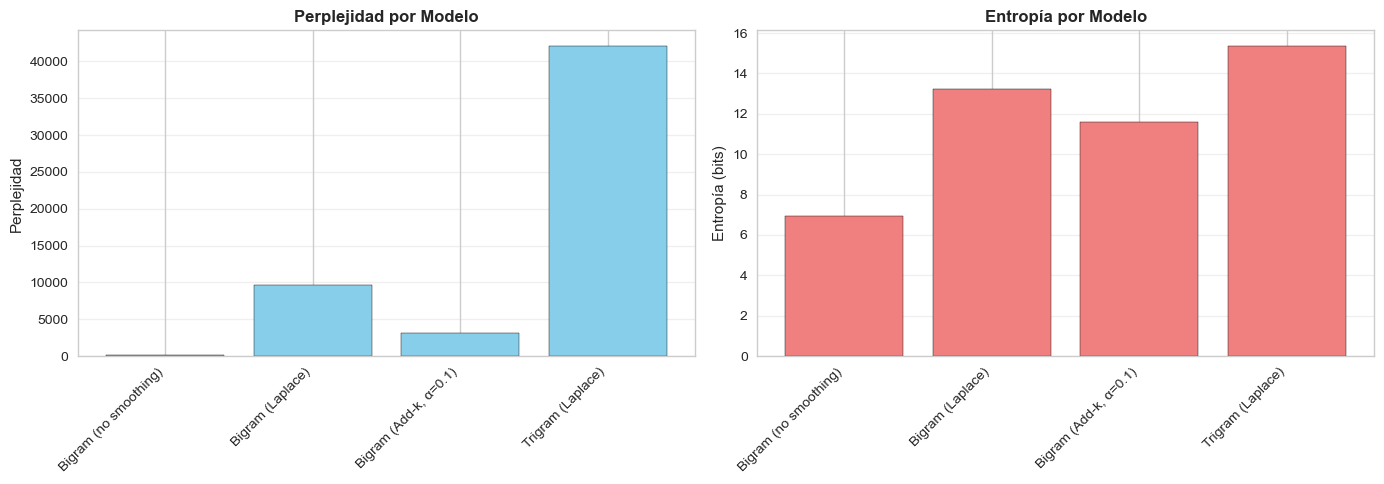

In [14]:
# ---------------------------------------------------------------------------
# 4.3 EVALUAR MODELOS - ENTROPÍA Y PERPLEJIDAD
# ---------------------------------------------------------------------------

print("\n" + "-"*80)
print("4.3 EVALUACIÓN: ENTROPÍA Y PERPLEJIDAD")
print("-"*80)

# Usar muestra más pequeña para evaluar (más rápido)
test_sample_size = min(1000, len(test_tokens))
test_sample = test_tokens[:test_sample_size]

results = {}
print("\n📊 Evaluando modelos en conjunto de test...")
print("─"*80)

for name, model in models.items():
    print(f"\n🔄 Evaluando: {name}")
    
    start_time = time.time()
    entropy = model.entropy(test_sample)
    perplexity = model.perplexity(test_sample)
    eval_time = time.time() - start_time
    
    results[name] = {
        'entropy': entropy,
        'perplexity': perplexity,
        'time': eval_time
    }
    
    print(f"   ├─ Entropía: {entropy:.4f} bits")
    print(f"   ├─ Perplejidad: {perplexity:.2f}")
    print(f"   └─ Tiempo: {eval_time:.2f}s")

# Crear tabla comparativa
print("\n" + "="*80)
print("TABLA COMPARATIVA DE MODELOS N-GRAMAS")
print("="*80)
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
print(results_df.to_string())

# Visualización de resultados
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfica de perplejidad
models_names = list(results.keys())
perplexities = [results[m]['perplexity'] for m in models_names]
axes[0].bar(range(len(models_names)), perplexities, color='skyblue', edgecolor='black')
axes[0].set_xticks(range(len(models_names)))
axes[0].set_xticklabels(models_names, rotation=45, ha='right')
axes[0].set_ylabel('Perplejidad')
axes[0].set_title('Perplejidad por Modelo', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Gráfica de entropía
entropies = [results[m]['entropy'] for m in models_names]
axes[1].bar(range(len(models_names)), entropies, color='lightcoral', edgecolor='black')
axes[1].set_xticks(range(len(models_names)))
axes[1].set_xticklabels(models_names, rotation=45, ha='right')
axes[1].set_ylabel('Entropía (bits)')
axes[1].set_title('Entropía por Modelo', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/ngram_evaluation.png', dpi=300, bbox_inches='tight')
print("\n✅ Gráficas guardadas: ngram_evaluation.png")
plt.show()

In [15]:
# ---------------------------------------------------------------------------
# 4.4 GENERACIÓN DE TEXTO
# ---------------------------------------------------------------------------

print("\n" + "-"*80)
print("4.4 GENERACIÓN DE TEXTO CON N-GRAMAS")
print("-"*80)

print("\n📝 Ejemplos de generación de texto:")
print("─"*80)

# Generar con diferentes modelos
for name, model in list(models.items())[:2]:  # Solo primeros 2 modelos
    print(f"\n🔤 {name}:")
    for i in range(3):
        generated = model.generate_text(max_length=15)
        print(f"   {i+1}. {generated}")


--------------------------------------------------------------------------------
4.4 GENERACIÓN DE TEXTO CON N-GRAMAS
--------------------------------------------------------------------------------

📝 Ejemplos de generación de texto:
────────────────────────────────────────────────────────────────────────────────

🔤 Bigram (no smoothing):
   1. this country safar under led upar rejected voters indio created indiar army airforce raid janardan
   2. because such hate for livingplz find onir should not support bjp sure peoplir like vision
   3. plz darir you come with nyay bekar

🔤 Bigram (Laplace):
   1. dear hon precident bjp ruled india emerged some politician clearly show incomplte knowledge whichand when
   2. would see nawaz sharif were having such thing happened after announced that the reason why
   3. the corrupt but least important message pak their hats off you sycophants


In [16]:
# ---------------------------------------------------------------------------
# 4.5 ANÁLISIS DE N-GRAMAS MÁS FRECUENTES
# ---------------------------------------------------------------------------

print("\n" + "-"*80)
print("4.5 ANÁLISIS DE N-GRAMAS MÁS FRECUENTES")
print("-"*80)

# Top bigramas
print("\n🔝 Top 20 Bigramas más frecuentes:")
print("─"*80)
top_bigrams = bigram_laplace.ngram_counts.most_common(20)
for i, (bigram, count) in enumerate(top_bigrams, 1):
    if '<START>' not in bigram and '<END>' not in bigram:
        print(f"   {i:2d}. {' '.join(bigram):30s} | {count:,} veces")

# Top trigramas
print("\n🔝 Top 20 Trigramas más frecuentes:")
print("─"*80)
top_trigrams = trigram_laplace.ngram_counts.most_common(20)
for i, (trigram, count) in enumerate(top_trigrams, 1):
    if '<START>' not in trigram and '<END>' not in trigram:
        print(f"   {i:2d}. {' '.join(trigram):40s} | {count:,} veces")

# Guardar modelos
print("\n💾 Guardando modelos N-gramas...")
with open('../models/ngram_models.pkl', 'wb') as f:
    pickle.dump(models, f)
print("✅ Modelos guardados: ngram_models.pkl")

print("\n" + "="*80)
print("✅ SECCIÓN 4 COMPLETADA: MODELOS PROBABILÍSTICOS")
print("="*80)
print("\nResultados:")
print("   ✅ 4 modelos N-gramas entrenados")
print("   ✅ Entropía y perplejidad calculadas")
print("   ✅ Comparación de técnicas de smoothing")
print("   ✅ Generación de texto implementada")


--------------------------------------------------------------------------------
4.5 ANÁLISIS DE N-GRAMAS MÁS FRECUENTES
--------------------------------------------------------------------------------

🔝 Top 20 Bigramas más frecuentes:
────────────────────────────────────────────────────────────────────────────────
    1. you are                        | 4,241 veces
    3. vote for                       | 3,807 veces
    4. for the                        | 3,734 veces
    5. prime minister                 | 3,204 veces
    8. rahul gandhi                   | 2,482 veces
    9. all the                        | 2,163 veces
   10. the nation                     | 2,123 veces
   11. the country                    | 2,037 veces
   12. they are                       | 1,970 veces
   17. and the                        | 1,635 veces
   18. you have                       | 1,521 veces
   20. the samir                      | 1,461 veces

🔝 Top 20 Trigramas más frecuentes:
─────────────────────

# -----
# SECCIÓN 5: CLASIFICACIÓN SUPERVISADA
# -----

In [17]:
print("\n" + "="*80)
print("SECCIÓN 5: CLASIFICACIÓN SUPERVISADA")
print("="*80)

# ---------------------------------------------------------------------------
# 5.1 PREPARACIÓN DE DATOS
# ---------------------------------------------------------------------------

print("\n" + "-"*80)
print("5.1 PREPARACIÓN DE DATOS PARA CLASIFICACIÓN")
print("-"*80)

# Dividir datos en train/test (80/20)
print("\n🔄 Dividiendo datos en train/test (80/20)...")

# Para representaciones sparse (BoW, TF-IDF)
from sklearn.model_selection import train_test_split

X_bow_train, X_bow_test, y_train, y_test = train_test_split(
    X_bow, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

X_tfidf_train, X_tfidf_test, _, _ = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

X_w2v_train, X_w2v_test, _, _ = train_test_split(
    X_w2v, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

X_fasttext_train, X_fasttext_test, _, _ = train_test_split(
    X_fasttext, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

print(f"✅ Datos divididos:")
print(f"   ├─ Train: {len(y_train):,} documentos")
print(f"   ├─ Test: {len(y_test):,} documentos")
print(f"   └─ Distribución de clases:")

for class_label in np.unique(y):
    train_count = (y_train == class_label).sum()
    test_count = (y_test == class_label).sum()
    print(f"      Clase {int(class_label)}: Train={train_count:,} | Test={test_count:,}")


SECCIÓN 5: CLASIFICACIÓN SUPERVISADA

--------------------------------------------------------------------------------
5.1 PREPARACIÓN DE DATOS PARA CLASIFICACIÓN
--------------------------------------------------------------------------------

🔄 Dividiendo datos en train/test (80/20)...
✅ Datos divididos:
   ├─ Train: 130,068 documentos
   ├─ Test: 32,518 documentos
   └─ Distribución de clases:
      Clase -1: Train=28,398 | Test=7,100
      Clase 0: Train=43,928 | Test=10,982
      Clase 1: Train=57,742 | Test=14,436


In [18]:
# ---------------------------------------------------------------------------
# 5.2 FUNCIÓN DE EVALUACIÓN
# ---------------------------------------------------------------------------

def evaluate_model(y_true, y_pred, y_proba=None, model_name="Model"):
    """Evalúa un modelo de clasificación y muestra métricas"""
    
    print(f"\n📊 Evaluación: {model_name}")
    print("─"*80)
    
    # Métricas básicas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    
    # Classification report
    print(f"\n   Classification Report:")
    print("   " + "-"*76)
    report = classification_report(y_true, y_pred, zero_division=0)
    for line in report.split('\n'):
        print(f"   {line}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'y_pred': y_pred
    }

In [19]:
# ---------------------------------------------------------------------------
# 5.3 NAIVE BAYES
# ---------------------------------------------------------------------------

print("\n" + "-"*80)
print("5.3 NAIVE BAYES")
print("-"*80)

# Naive Bayes con BoW
print("\n🔄 Entrenando Naive Bayes (BoW)...")
nb_bow = MultinomialNB(alpha=1.0)
nb_bow.fit(X_bow_train, y_train)
y_pred_nb_bow = nb_bow.predict(X_bow_test)
results_nb_bow = evaluate_model(y_test, y_pred_nb_bow, model_name="Naive Bayes (BoW)")

# Naive Bayes con TF-IDF
print("\n🔄 Entrenando Naive Bayes (TF-IDF)...")
nb_tfidf = MultinomialNB(alpha=1.0)
nb_tfidf.fit(X_tfidf_train, y_train)
y_pred_nb_tfidf = nb_tfidf.predict(X_tfidf_test)
results_nb_tfidf = evaluate_model(y_test, y_pred_nb_tfidf, model_name="Naive Bayes (TF-IDF)")


--------------------------------------------------------------------------------
5.3 NAIVE BAYES
--------------------------------------------------------------------------------

🔄 Entrenando Naive Bayes (BoW)...

📊 Evaluación: Naive Bayes (BoW)
────────────────────────────────────────────────────────────────────────────────
   Accuracy:  0.7853
   Precision: 0.7911
   Recall:    0.7853
   F1-Score:  0.7855

   Classification Report:
   ----------------------------------------------------------------------------
                 precision    recall  f1-score   support
   
           -1.0       0.69      0.73      0.71      7100
            0.0       0.87      0.74      0.80     10982
            1.0       0.78      0.85      0.81     14436
   
       accuracy                           0.79     32518
      macro avg       0.78      0.77      0.77     32518
   weighted avg       0.79      0.79      0.79     32518
   

🔄 Entrenando Naive Bayes (TF-IDF)...

📊 Evaluación: Naive Bayes (TF-I

In [45]:
# ---------------------------------------------------------------------------
# 5.4 SUPPORT VECTOR MACHINE (SVM) tipo GPU con PyTorch
# ---------------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import LinearSVC
import numpy as np

print("\n" + "-"*80)
print("5.4 SUPPORT VECTOR MACHINE (SVM) - GPU/CPU con PyTorch")
print("-"*80)

# -------------------------------
# Detectar dispositivo
# -------------------------------
device = torch.device("cpu")  # asegura que funcione antes de pasar a GPU
print(f"\n💻 Usando dispositivo: {device}")

# ===============================
# 1️⃣ SVM CLÁSICO (CPU) - TF-IDF
# ===============================
print("\n🔄 Entrenando SVM (TF-IDF, CPU)...")
svm_tfidf = LinearSVC(C=1.0, max_iter=1000, random_state=RANDOM_SEED)
svm_tfidf.fit(X_tfidf_train, y_train)
y_pred_svm_tfidf = svm_tfidf.predict(X_tfidf_test)
results_svm_tfidf = evaluate_model(y_test, y_pred_svm_tfidf, model_name="SVM (TF-IDF)")

# ===============================
# 2️⃣ SVM tipo GPU (PyTorch) - Word2Vec
# ===============================
print("\n🔄 Entrenando SVM tipo GPU (Word2Vec, PyTorch)...")

# -------------------------------
# Normalizar embeddings
# -------------------------------
scaler_w2v = StandardScaler()
X_train_scaled = scaler_w2v.fit_transform(X_w2v_train)
X_test_scaled  = scaler_w2v.transform(X_w2v_test)

# -------------------------------
# Reemplazar NaNs o Inf
# -------------------------------
X_train_scaled = np.nan_to_num(X_train_scaled)
X_test_scaled  = np.nan_to_num(X_test_scaled)

# -------------------------------
# Convertir etiquetas a 0..N-1
# -------------------------------
le_w2v = LabelEncoder()
y_train_idx = le_w2v.fit_transform(y_train)
y_test_idx  = le_w2v.transform(y_test)

# -------------------------------
# Validar rango de etiquetas
# -------------------------------
num_classes_w2v = len(le_w2v.classes_)
assert y_train_idx.min() >= 0 and y_train_idx.max() < num_classes_w2v
assert y_test_idx.min() >= 0 and y_test_idx.max() < num_classes_w2v

# -------------------------------
# Convertir a tensores GPU/CPU
# -------------------------------
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train_idx, dtype=torch.long).to(device)
X_test_t  = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_t  = torch.tensor(y_test_idx, dtype=torch.long).to(device)

# -------------------------------
# Definir modelo lineal (equivalente a SVM lineal)
# -------------------------------
class LinearSVM(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.fc(x)

svm_w2v_pytorch = LinearSVM(X_train_t.shape[1], num_classes_w2v).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(svm_w2v_pytorch.parameters(), lr=1e-3)

# -------------------------------
# Entrenamiento con barra de progreso
# -------------------------------
batch_size = 128
epochs = 20

for epoch in range(epochs):
    svm_w2v_pytorch.train()
    running_loss = 0.0
    
    for i in tqdm(range(0, len(X_train_t), batch_size), desc=f"Época {epoch+1}/{epochs}"):
        batch_X = X_train_t[i:i+batch_size]
        batch_y = y_train_t[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = svm_w2v_pytorch(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / (len(X_train_t) / batch_size)
    print(f"   🔹 Pérdida media: {avg_loss:.4f}")

# -------------------------------
# Evaluación
# -------------------------------
svm_w2v_pytorch.eval()
with torch.no_grad():
    preds_idx = svm_w2v_pytorch(X_test_t).argmax(dim=1).cpu().numpy()

# Convertir predicciones de índices de vuelta a las etiquetas originales
preds_original = le_w2v.inverse_transform(preds_idx)

results_svm_w2v = evaluate_model(y_test, preds_original, model_name="SVM (Word2Vec PyTorch)")

print("\n✅ Entrenamiento finalizado con GPU/CPU PyTorch Linear SVM.")


--------------------------------------------------------------------------------
5.4 SUPPORT VECTOR MACHINE (SVM) - GPU/CPU con PyTorch
--------------------------------------------------------------------------------

💻 Usando dispositivo: cpu

🔄 Entrenando SVM (TF-IDF, CPU)...

📊 Evaluación: SVM (TF-IDF)
────────────────────────────────────────────────────────────────────────────────
   Accuracy:  0.9392
   Precision: 0.9388
   Recall:    0.9392
   F1-Score:  0.9388

   Classification Report:
   ----------------------------------------------------------------------------
                 precision    recall  f1-score   support
   
           -1.0       0.91      0.87      0.89      7100
            0.0       0.95      0.97      0.96     10982
            1.0       0.94      0.95      0.95     14436
   
       accuracy                           0.94     32518
      macro avg       0.94      0.93      0.93     32518
   weighted avg       0.94      0.94      0.94     32518
   

🔄 Entren

Época 1/20: 100%|██████████| 1017/1017 [00:00<00:00, 1887.40it/s]


   🔹 Pérdida media: 0.9397


Época 2/20: 100%|██████████| 1017/1017 [00:00<00:00, 2108.73it/s]


   🔹 Pérdida media: 0.8957


Época 3/20: 100%|██████████| 1017/1017 [00:00<00:00, 2102.00it/s]


   🔹 Pérdida media: 0.8941


Época 4/20: 100%|██████████| 1017/1017 [00:00<00:00, 2108.64it/s]


   🔹 Pérdida media: 0.8939


Época 5/20: 100%|██████████| 1017/1017 [00:00<00:00, 2201.27it/s]


   🔹 Pérdida media: 0.8938


Época 6/20: 100%|██████████| 1017/1017 [00:00<00:00, 2149.15it/s]


   🔹 Pérdida media: 0.8937


Época 7/20: 100%|██████████| 1017/1017 [00:00<00:00, 2167.00it/s]


   🔹 Pérdida media: 0.8937


Época 8/20: 100%|██████████| 1017/1017 [00:00<00:00, 1842.25it/s]


   🔹 Pérdida media: 0.8937


Época 9/20: 100%|██████████| 1017/1017 [00:00<00:00, 2247.56it/s]


   🔹 Pérdida media: 0.8937


Época 10/20: 100%|██████████| 1017/1017 [00:00<00:00, 2125.25it/s]


   🔹 Pérdida media: 0.8937


Época 11/20: 100%|██████████| 1017/1017 [00:00<00:00, 2264.91it/s]


   🔹 Pérdida media: 0.8937


Época 12/20: 100%|██████████| 1017/1017 [00:00<00:00, 2255.67it/s]


   🔹 Pérdida media: 0.8937


Época 13/20: 100%|██████████| 1017/1017 [00:00<00:00, 2253.88it/s]


   🔹 Pérdida media: 0.8937


Época 14/20: 100%|██████████| 1017/1017 [00:00<00:00, 2246.99it/s]


   🔹 Pérdida media: 0.8937


Época 15/20: 100%|██████████| 1017/1017 [00:00<00:00, 2224.83it/s]


   🔹 Pérdida media: 0.8937


Época 16/20: 100%|██████████| 1017/1017 [00:00<00:00, 2082.38it/s]


   🔹 Pérdida media: 0.8937


Época 17/20: 100%|██████████| 1017/1017 [00:00<00:00, 1740.38it/s]


   🔹 Pérdida media: 0.8937


Época 18/20: 100%|██████████| 1017/1017 [00:00<00:00, 2129.77it/s]


   🔹 Pérdida media: 0.8937


Época 19/20: 100%|██████████| 1017/1017 [00:00<00:00, 2208.83it/s]


   🔹 Pérdida media: 0.8937


Época 20/20: 100%|██████████| 1017/1017 [00:00<00:00, 2171.02it/s]


   🔹 Pérdida media: 0.8937

📊 Evaluación: SVM (Word2Vec PyTorch)
────────────────────────────────────────────────────────────────────────────────
   Accuracy:  0.5805
   Precision: 0.5664
   Recall:    0.5805
   F1-Score:  0.5630

   Classification Report:
   ----------------------------------------------------------------------------
                 precision    recall  f1-score   support
   
           -1.0       0.47      0.24      0.32      7100
            0.0       0.58      0.60      0.59     10982
            1.0       0.60      0.73      0.66     14436
   
       accuracy                           0.58     32518
      macro avg       0.55      0.52      0.52     32518
   weighted avg       0.57      0.58      0.56     32518
   

✅ Entrenamiento finalizado con GPU/CPU PyTorch Linear SVM.


In [ ]:
# ---------------------------------------------------------------------------
# 5.5 LOGISTIC REGRESSION
# ---------------------------------------------------------------------------

print("\n" + "-"*80)
print("5.5 LOGISTIC REGRESSION")
print("-"*80)

print("\n🔄 Entrenando Logistic Regression (TF-IDF)...")
lr_tfidf = LogisticRegression(C=1.0, max_iter=1000, random_state=RANDOM_SEED)
lr_tfidf.fit(X_tfidf_train, y_train)
y_pred_lr_tfidf = lr_tfidf.predict(X_tfidf_test) 
results_lr_tfidf = evaluate_model(y_test, y_pred_lr_tfidf, model_name="Logistic Regression (TF-IDF)")


--------------------------------------------------------------------------------
5.5 LOGISTIC REGRESSION
--------------------------------------------------------------------------------

🔄 Entrenando Logistic Regression (TF-IDF)...

📊 Evaluación: Logistic Regression (TF-IDF)
────────────────────────────────────────────────────────────────────────────────
   Accuracy:  0.9241
   Precision: 0.9238
   Recall:    0.9241
   F1-Score:  0.9232

   Classification Report:
   ----------------------------------------------------------------------------
                 precision    recall  f1-score   support
   
           -1.0       0.91      0.82      0.86      7100
            0.0       0.92      0.97      0.95     10982
            1.0       0.94      0.94      0.94     14436
   
       accuracy                           0.92     32518
      macro avg       0.92      0.91      0.91     32518
   weighted avg       0.92      0.92      0.92     32518
   


In [34]:
# ---------------------------------------------------------------------------
# 5.6 RANDOM FOREST
# ---------------------------------------------------------------------------

print("\n" + "-"*80)
print("5.6 RANDOM FOREST")
print("-"*80)

print("\n🔄 Entrenando Random Forest (Word2Vec)...")
rf_w2v = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
rf_w2v.fit(X_w2v_train, y_train)
y_pred_rf_w2v = rf_w2v.predict(X_w2v_test)
results_rf_w2v = evaluate_model(y_test, y_pred_rf_w2v, model_name="Random Forest (Word2Vec)")


--------------------------------------------------------------------------------
5.6 RANDOM FOREST
--------------------------------------------------------------------------------

🔄 Entrenando Random Forest (Word2Vec)...

📊 Evaluación: Random Forest (Word2Vec)
────────────────────────────────────────────────────────────────────────────────
   Accuracy:  0.6289
   Precision: 0.6329
   Recall:    0.6289
   F1-Score:  0.6005

   Classification Report:
   ----------------------------------------------------------------------------
                 precision    recall  f1-score   support
   
           -1.0       0.64      0.20      0.31      7100
            0.0       0.66      0.67      0.67     10982
            1.0       0.61      0.80      0.69     14436
   
       accuracy                           0.63     32518
      macro avg       0.64      0.56      0.56     32518
   weighted avg       0.63      0.63      0.60     32518
   


In [40]:
# ---------------------------------------------------------------------------
# 5.7 REDES NEURONALES CONVOLUCIONALES (CNN) - CPU ONLY
# ---------------------------------------------------------------------------
# Run this AFTER restarting kernel
# Put this at the very top of your notebook BEFORE any other imports:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

if PYTORCH_AVAILABLE:
    print("\n" + "-"*80)
    print("5.7 CONVOLUTIONAL NEURAL NETWORK (CNN)")
    print("-"*80)
    
    # Definir arquitectura CNN
    class TextCNN(nn.Module):
        def __init__(self, vocab_size, embedding_dim, num_classes, num_filters=100, 
                     filter_sizes=[3, 4, 5], dropout=0.5):
            super(TextCNN, self).__init__()
            
            # Capa de embedding
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
            
            # Capas convolucionales
            self.convs = nn.ModuleList([
                nn.Conv2d(1, num_filters, (fs, embedding_dim))
                for fs in filter_sizes
            ])
            
            # Dropout y fully connected
            self.dropout = nn.Dropout(dropout)
            self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
        
        def forward(self, x):
            # x shape: (batch_size, seq_length)
            x = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
            x = x.unsqueeze(1)     # (batch_size, 1, seq_length, embedding_dim)
            
            # Aplicar convoluciones y max pooling
            x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]
            x = [torch.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
            
            # Concatenar
            x = torch.cat(x, 1)
            x = self.dropout(x)
            x = self.fc(x)
            
            return x
    
    print("\n🔄 Preparando datos para CNN...")
    
    # Crear vocabulario y tokenizar
    from sklearn.preprocessing import LabelEncoder
    
    # CRITICAL FIX: Encode labels to ensure they start from 0
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    print(f"\n📊 Verificando etiquetas:")
    print(f"   Etiquetas originales únicas: {np.unique(y)}")
    print(f"   Etiquetas codificadas: {np.unique(y_encoded)}")
    print(f"   Número de clases: {len(np.unique(y_encoded))}")
    
    # Mapear palabras a índices
    word_to_idx_cnn = {word: idx + 1 for idx, word in enumerate(bow_feature_names)}
    word_to_idx_cnn['<PAD>'] = 0
    word_to_idx_cnn['<UNK>'] = len(word_to_idx_cnn)
    
    print(f"   Vocab size: {len(word_to_idx_cnn)}")
    
    def tokens_to_indices(tokens, word_to_idx, max_len=100):
        indices = [word_to_idx.get(token, word_to_idx['<UNK>']) for token in tokens[:max_len]]
        # Padding
        if len(indices) < max_len:
            indices += [word_to_idx['<PAD>']] * (max_len - len(indices))
        return indices
    
    # Convertir tokens a índices
    X_cnn = np.array([tokens_to_indices(tokens, word_to_idx_cnn) for tokens in X_tokens])
    
    print(f"   X_cnn shape: {X_cnn.shape}")
    print(f"   X_cnn min: {X_cnn.min()}, max: {X_cnn.max()}")
    
    # Use encoded labels
    X_cnn_train, X_cnn_test, y_train_cnn, y_test_cnn = train_test_split(
        X_cnn, y_encoded, test_size=0.2, random_state=RANDOM_SEED, stratify=y_encoded
    )
    
    # Convertir a tensores de PyTorch
    X_cnn_train_tensor = torch.LongTensor(X_cnn_train)
    X_cnn_test_tensor = torch.LongTensor(X_cnn_test)
    y_train_tensor = torch.LongTensor(y_train_cnn)
    y_test_tensor = torch.LongTensor(y_test_cnn)
    
    # Verify tensor ranges
    print(f"\n📊 Verificando tensores:")
    print(f"   X_train shape: {X_cnn_train_tensor.shape}")
    print(f"   X_train rango: {X_cnn_train_tensor.min().item()} a {X_cnn_train_tensor.max().item()}")
    print(f"   y_train rango: {y_train_tensor.min().item()} a {y_train_tensor.max().item()}")
    print(f"   y_test rango: {y_test_tensor.min().item()} a {y_test_tensor.max().item()}")
    
    # Dataset y DataLoader
    class TextDataset(Dataset):
        def __init__(self, X, y):
            self.X = X
            self.y = y
        
        def __len__(self):
            return len(self.y)
        
        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]
    
    train_dataset = TextDataset(X_cnn_train_tensor, y_train_tensor)
    test_dataset = TextDataset(X_cnn_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Force CPU usage
    device = torch.device('cpu')
    print(f"\n   Dispositivo: {device}")
    
    num_classes = len(np.unique(y_encoded))
    print(f"   Número de clases para el modelo: {num_classes}")
    
    # Create model
    model_cnn = TextCNN(
        vocab_size=len(word_to_idx_cnn),
        embedding_dim=100,
        num_classes=num_classes
    ).to(device)
    
    print("   ✓ Modelo creado")
    
    # Entrenar
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
    
    print("\n🔄 Entrenando CNN...")
    num_epochs = 5
    
    for epoch in range(num_epochs):
        model_cnn.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (batch_x, batch_y) in enumerate(train_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # Debug first batch
            if epoch == 0 and batch_idx == 0:
                print(f"   Primer batch:")
                print(f"      X shape: {batch_x.shape}, rango: [{batch_x.min()}, {batch_x.max()}]")
                print(f"      y shape: {batch_y.shape}, rango: [{batch_y.min()}, {batch_y.max()}]")
            
            optimizer.zero_grad()
            outputs = model_cnn(batch_x)
            
            # Verify output shape
            if epoch == 0 and batch_idx == 0:
                print(f"      Output shape: {outputs.shape}")
                print(f"      Expected classes: {num_classes}")
            
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
        
        accuracy = 100 * correct / total
        avg_loss = total_loss / len(train_loader)
        print(f"   Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")
    
    # Evaluar
    print("\n🔄 Evaluando CNN...")
    model_cnn.eval()
    y_pred_cnn = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            outputs = model_cnn(batch_x)
            _, predicted = torch.max(outputs, 1)
            y_pred_cnn.extend(predicted.cpu().numpy())
    
    # Decode predictions back to original labels for evaluation
    y_test_original = le.inverse_transform(y_test_cnn)
    y_pred_original = le.inverse_transform(np.array(y_pred_cnn))
    
    results_cnn = evaluate_model(y_test_original, y_pred_original, model_name="CNN (PyTorch)")
    
    print("\n✅ CNN entrenado y evaluado exitosamente")


--------------------------------------------------------------------------------
5.7 CONVOLUTIONAL NEURAL NETWORK (CNN)
--------------------------------------------------------------------------------

🔄 Preparando datos para CNN...

📊 Verificando etiquetas:
   Etiquetas originales únicas: [-1.  0.  1.]
   Etiquetas codificadas: [0 1 2]
   Número de clases: 3
   Vocab size: 5002
   X_cnn shape: (162586, 100)
   X_cnn min: 0, max: 5001

📊 Verificando tensores:
   X_train shape: torch.Size([130068, 100])
   X_train rango: 0 a 5001
   y_train rango: 0 a 2
   y_test rango: 0 a 2

   Dispositivo: cpu
   Número de clases para el modelo: 3
   ✓ Modelo creado

🔄 Entrenando CNN...
   Primer batch:
      X shape: torch.Size([64, 100]), rango: [0, 5001]
      y shape: torch.Size([64]), rango: [0, 2]
      Output shape: torch.Size([64, 3])
      Expected classes: 3
   Epoch 1/5 | Loss: 0.6329 | Accuracy: 73.94%
   Epoch 2/5 | Loss: 0.3131 | Accuracy: 90.60%
   Epoch 3/5 | Loss: 0.2563 | Accuracy:


5.8 COMPARACIÓN DE TODOS LOS MODELOS

📊 TABLA COMPARATIVA DE MODELOS
                      Accuracy  Precision  Recall  F1-Score
Naive Bayes (BoW)       0.7853     0.7911  0.7853    0.7855
Naive Bayes (TF-IDF)    0.7311     0.7778  0.7311    0.7175
SVM (TF-IDF)            0.9392     0.9388  0.9392    0.9388
SVM (Word2Vec)          0.5805     0.5664  0.5805    0.5630
Logistic Regression     0.9241     0.9238  0.9241    0.9232
Random Forest           0.6289     0.6329  0.6289    0.6005
CNN                     0.9389     0.9400  0.9389    0.9391

✅ Gráfica guardada: models_comparison.png


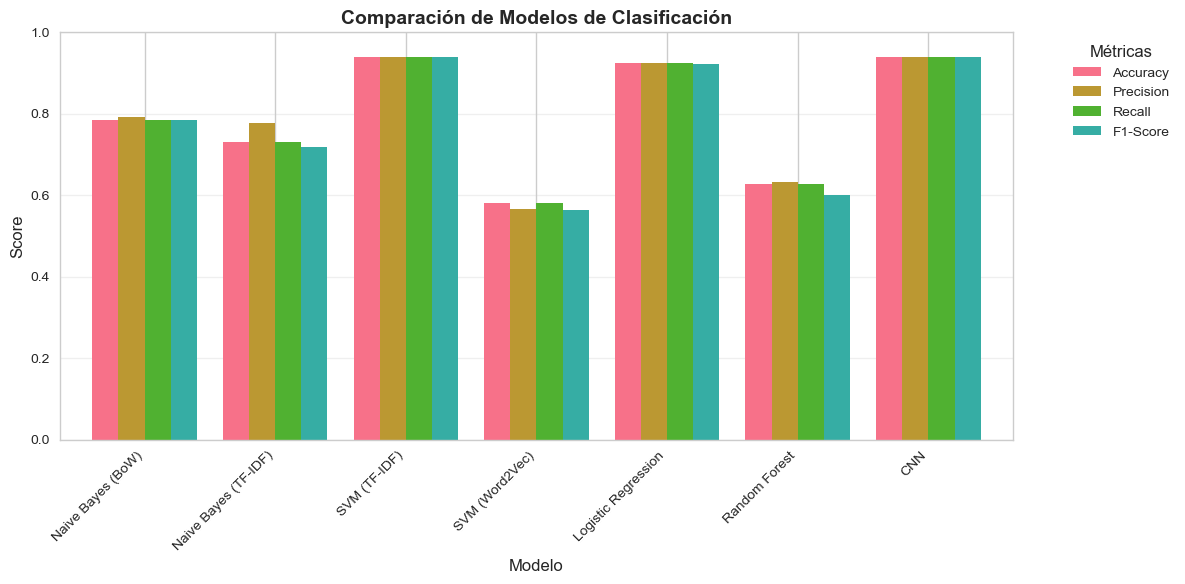


🏆 MEJOR MODELO: CNN
   F1-Score: 0.9391
✅ Matriz de confusión guardada


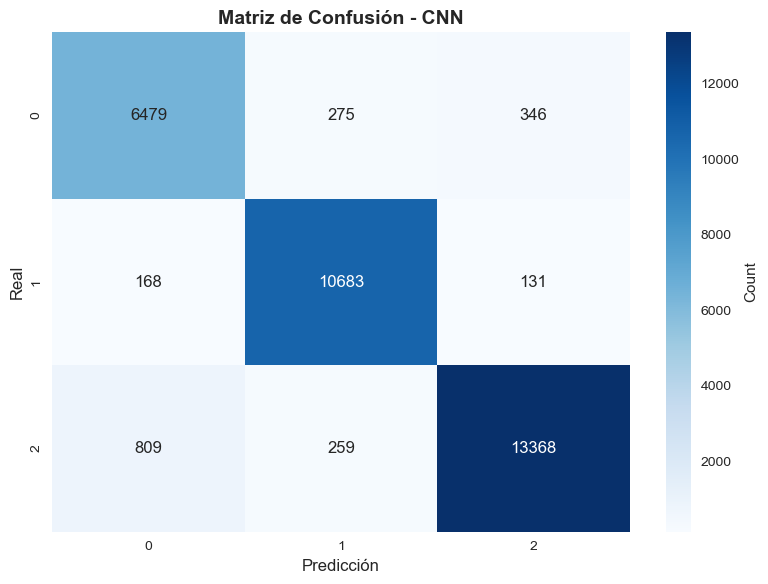


💾 Guardando modelos entrenados...
   ✅ CNN guardado: cnn_model.pth
   ✅ SVM PyTorch guardado: svm_pytorch.pth
   ✅ Modelos guardados: classification_models.pkl
   ✅ Resultados guardados: classification_results.json

✅ PIPELINE COMPLETO FINALIZADO

🎉 RESUMEN DEL PROYECTO:
   ✅ Representaciones de texto: BoW, TF-IDF, Co-ocurrencia, PPMI, Word2Vec, FastText
   ✅ Modelos probabilísticos: 4 modelos N-gramas con evaluación
   ✅ Clasificación: 7 modelos entrenados y comparados
   🏆 Mejor modelo: CNN (F1=0.9391)

📁 Archivos generados:
   ├─ data/processed/representations.pkl
   ├─ data/embeddings/word2vec.model
   ├─ data/embeddings/fasttext.model
   ├─ models/ngram_models.pkl
   ├─ models/classification_models.pkl
   ├─ models/cnn_model.pth
   ├─ results/representations_pca.png
   ├─ results/tsne_word2vec.png
   ├─ results/ngram_evaluation.png
   ├─ results/models_comparison.png
   └─ results/classification_results.json



In [46]:
# ---------------------------------------------------------------------------
# 5.8 COMPARACIÓN DE MODELOS
# ---------------------------------------------------------------------------
print("\n" + "="*80)
print("5.8 COMPARACIÓN DE TODOS LOS MODELOS")
print("="*80)

# Recopilar resultados
all_results = {
    'Naive Bayes (BoW)': results_nb_bow,
    'Naive Bayes (TF-IDF)': results_nb_tfidf,
    'SVM (TF-IDF)': results_svm_tfidf,
    'SVM (Word2Vec)': results_svm_w2v,
    'Logistic Regression': results_lr_tfidf,
    'Random Forest': results_rf_w2v,
}

if PYTORCH_AVAILABLE:
    all_results['CNN'] = results_cnn

# Crear tabla comparativa
comparison_df = pd.DataFrame({
    name: {
        'Accuracy': res['accuracy'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1-Score': res['f1']
    }
    for name, res in all_results.items()
}).T

print("\n📊 TABLA COMPARATIVA DE MODELOS")
print("="*80)
print(comparison_df.round(4).to_string())

# Visualización comparativa
fig, ax = plt.subplots(figsize=(12, 6))
comparison_df.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Modelo', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparación de Modelos de Clasificación', fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])
plt.tight_layout()
plt.savefig('../results/models_comparison.png', dpi=300, bbox_inches='tight')
print("\n✅ Gráfica guardada: models_comparison.png")
plt.show()

# Matriz de confusión del mejor modelo
best_model_name = comparison_df['F1-Score'].idxmax()
best_model_results = all_results[best_model_name]

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"   F1-Score: {best_model_results['f1']:.4f}")

# Visualizar matriz de confusión
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(best_model_results['confusion_matrix'], annot=True, fmt='d', 
            cmap='Blues', ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicción', fontsize=12)
ax.set_ylabel('Real', fontsize=12)
ax.set_title(f'Matriz de Confusión - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'../results/confusion_matrix_{best_model_name.replace(" ", "_")}.png', 
            dpi=300, bbox_inches='tight')
print(f"✅ Matriz de confusión guardada")
plt.show()

# Guardar modelos entrenados
print("\n💾 Guardando modelos entrenados...")
models_to_save = {
    'nb_bow': nb_bow,
    'nb_tfidf': nb_tfidf,
    'svm_tfidf': svm_tfidf,
    'lr_tfidf': lr_tfidf,
    'rf_w2v': rf_w2v,
}

# Guardar modelos PyTorch por separado
if PYTORCH_AVAILABLE:
    # Guardar CNN
    torch.save(model_cnn.state_dict(), '../models/cnn_model.pth')
    print("   ✅ CNN guardado: cnn_model.pth")
    
    # Guardar SVM PyTorch (el modelo completo con sus pesos)
    torch.save({
        'model_state_dict': model.state_dict(),
        'scaler': scaler,
        'label_encoder': le,
        'num_classes': num_classes,
        'input_dim': X_train_t.shape[1]
    }, '../models/svm_pytorch.pth')
    print("   ✅ SVM PyTorch guardado: svm_pytorch.pth")

with open('../models/classification_models.pkl', 'wb') as f:
    pickle.dump(models_to_save, f)
print("   ✅ Modelos guardados: classification_models.pkl")

# Guardar resultados
results_summary = {
    'comparison': comparison_df.to_dict(),
    'best_model': best_model_name,
    'best_f1': float(best_model_results['f1']),
    'all_results': {name: {k: v if k != 'confusion_matrix' else v.tolist() 
                          for k, v in res.items() if k != 'y_pred'}
                    for name, res in all_results.items()}
}

with open('../results/classification_results.json', 'w') as f:
    json.dump(results_summary, f, indent=4)
print("   ✅ Resultados guardados: classification_results.json")

print("\n" + "="*80)
print("✅ PIPELINE COMPLETO FINALIZADO")
print("="*80)

print("\n🎉 RESUMEN DEL PROYECTO:")
print("   ✅ Representaciones de texto: BoW, TF-IDF, Co-ocurrencia, PPMI, Word2Vec, FastText")
print("   ✅ Modelos probabilísticos: 4 modelos N-gramas con evaluación")
print(f"   ✅ Clasificación: {len(all_results)} modelos entrenados y comparados")
print(f"   🏆 Mejor modelo: {best_model_name} (F1={best_model_results['f1']:.4f})")

print("\n📁 Archivos generados:")
print("   ├─ data/processed/representations.pkl")
print("   ├─ data/embeddings/word2vec.model")
print("   ├─ data/embeddings/fasttext.model")
print("   ├─ models/ngram_models.pkl")
print("   ├─ models/classification_models.pkl")
if PYTORCH_AVAILABLE:
    print("   ├─ models/cnn_model.pth")
print("   ├─ results/representations_pca.png")
print("   ├─ results/tsne_word2vec.png")
print("   ├─ results/ngram_evaluation.png")
print("   ├─ results/models_comparison.png")
print("   └─ results/classification_results.json")

print("\n" + "="*80)